In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte


## Now why did exact do that when gamma = 0

In [ ]:

def main():
    # Initialize the simulation parameters
    N = 3
    gamma_L= 1
    gamma_R = 1

    eps = 1

    mu_L= 1
    mu_R= 1.1
    T_L = 3
    T_R= 1
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1
  
    time = 50.0
    dt = 0.1
    nt = int(time/dt)
    #exact_diag_ham= build_exact_diag_hamiltonian(N,J, eps)
   # print("Exact Ham", exact_diag_ham)

   
    ham_real, ham_imag = hamiltonian_generation(N, eps, gamma_L, gamma_R, F_L, F_R,J)
    print("Ham imag", ham_imag)
    print("Ham real", ham_real)

    exact_diag_results, time_points = [],[]

    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real,N)
    #exact_diag_results, time_points = perform_exact_diag(gamma_L, gamma_R, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N,eps)

    print("VQTE initial state", vqte_init_state)
    print("Exact initial state:",exact_diag_init_state)
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    
    # # Output results
    output_results(vqte_results, exact_diag_results, time, nt, time_points)
    print(vqte_results[-1][-1])

Ham imag SparsePauliOp(['XXI', 'YYI', 'IXX', 'IYY', 'III', 'ZII', 'IIZ'],
              coeffs=[-0.25+0.j,  0.25+0.j,  0.  +0.j,  0.  +0.j,  0.5 +0.j, -0.  +0.j,
  0.  +0.j])
Ham real SparsePauliOp(['ZII', 'IZI', 'IIZ', 'XXI', 'YYI', 'IXX', 'IYY', 'XYI', 'YXI', 'IXY', 'IYX'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,
 -0. +0.j, -0. +0.j,  0. +0.j,  0. +0.j])
VQTE initial state Statevector([ 1.00000000e+00+7.34788079e-16j,
             -1.22464680e-16-5.99903913e-32j,
             -1.22464680e-16-5.99903913e-32j,
             -1.22464680e-16+2.73691106e-48j,
             -2.44929360e-16-8.99855870e-32j,
              4.49927935e-32-1.21543267e-63j,
             -1.22464680e-16+0.00000000e+00j,
              4.49927935e-32-1.46934081e-47j],
            dims=(2, 2, 2))
Exact initial state: []
Initial expectation values:
  Qubit 0: 0.0000
  Qubit 1: 0.0000
  Qubit 2: 0.0000
Step 1 out of 500
Step 2 out of 500
Step 3 out of 500
Step 4 out of

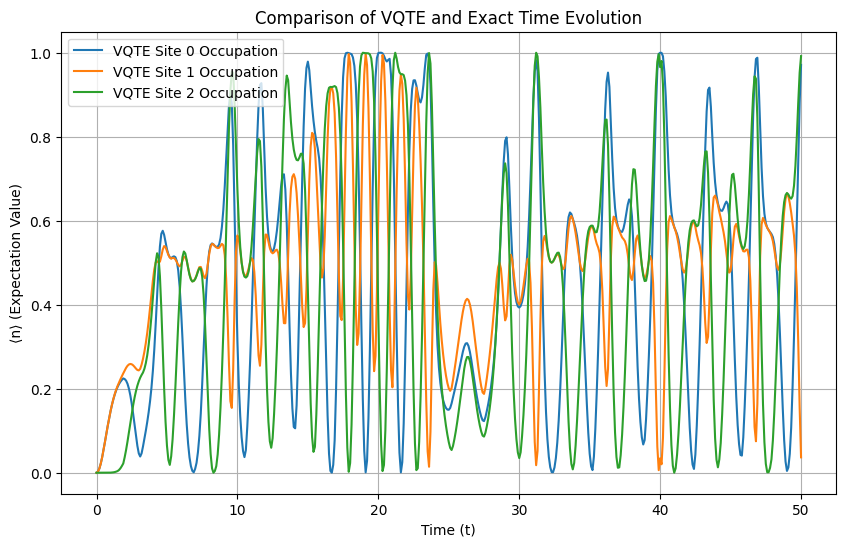

0.9919100207566977


In [3]:
main()